In [1]:
from torch.utils.data import Dataset, Subset
import torch
from PIL import Image
import torchvision
import os
import numpy as np
import random
import pandas as pd
import cv2
import torch.nn.functional as F
from Function import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [13]:
root_dir = "./examples/"
dataset = image_data(root_dir)
print(len(dataset))
dataset_example = torch.utils.data.DataLoader(dataset, batch_size=10)

10


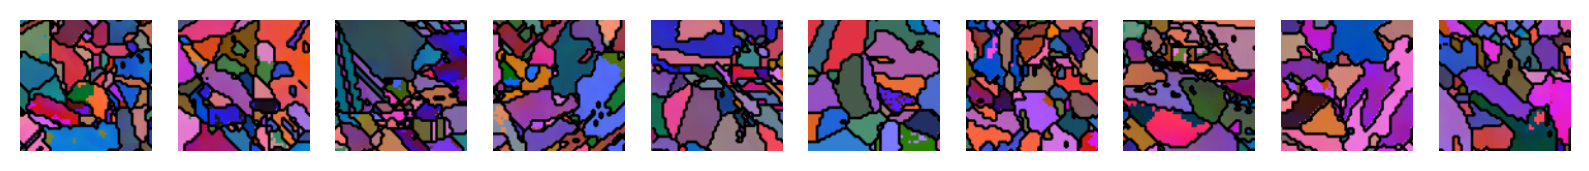

In [14]:
import matplotlib.pyplot as plt
show(next(iter(dataset_example)))

### VAE model

In [15]:
class Args:
  pass

args = Args()
args.batch_size = 64
args.epochs = 20
args.cuda = True
args.log_interval = 10
args.model = 'optimal_sigma_vae'  # Which model to use:  mse_vae,  gaussian_vae, or sigma_vae or optimal_sigma_vae

if not torch.cuda.is_available():
  args.cuda = False

vae = SigmaVAE(device, 3, args)

In [16]:
vae.load_state_dict(torch.load('./model_save/VAE.pt'))

<All keys matched successfully>

### Diffusion model

In [ ]:
diffusion = Diffusion(PretrainedConfig())
diffusion.load_state_dict(torch.load('./model_save/diffusVAE.pt'))

In [ ]:
def generate(n, device, out_vae):
    #Generation starting from random noise
    image = torch.randn(n, 3, 128, 128, device=device)
    
    mean = diffusion.norm.running_mean.reshape(1, 3, 1, 1)
    std = (diffusion.norm.running_var**0.5).reshape(1, 3, 1, 1)

    #Generation 20 steps
    for i in range(20):
        time = torch.full(size=(n, 1, 1, 1),
                          fill_value=(20 - i) / 20,
                          dtype=torch.float32,
                          device=device)

        #Random coefficients
        noise_r, image_r = schedule(time)

        #Combine noise image and noise coefficients
        #[b, 64, 64, 64]
        combine = diffusion.combine(image, noise_r**2, out_vae)

        #Predict noise from noise image
        pred_noise = diffusion.unet(combine)

        #Restore image based on predicted noise
        pred_image = (image - noise_r * pred_noise) / image_r

        #Recalculate random coefficients
        time = time - (1 / 20)
        noise_r, image_r = schedule(time)

        #Add noise back to the image for the next step calculation
        image = image_r * pred_image + noise_r * pred_noise

    pred_image = mean + pred_image * std
    pred_image = pred_image.clip(0.0, 1.0)
    
        
    return out_vae, pred_image

### Image reconstruction

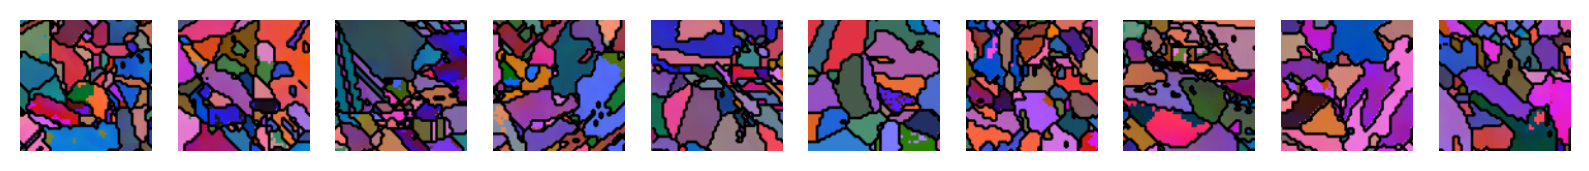

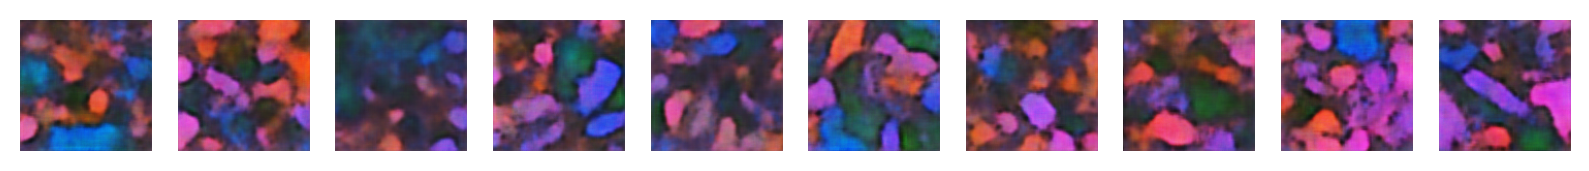

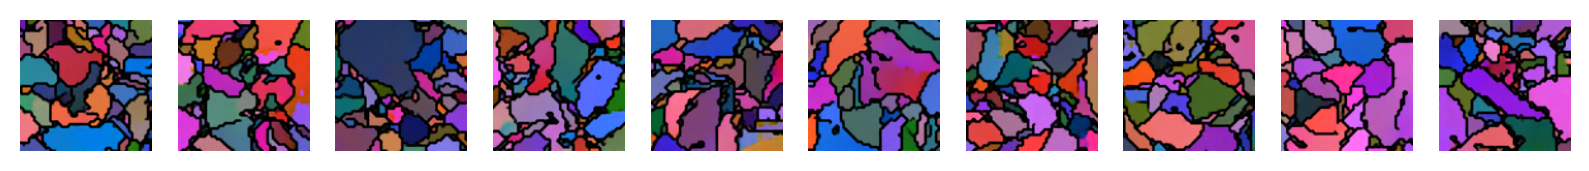

In [21]:
with torch.no_grad():
    vae.to(device)
    vae.eval()
    
    diffusion.to(device)
    diffusion.eval()
    images_original = next(iter(dataset_example))[0:10].to(device)
    images_vae, _, _ = vae(images_original)
    _, image_re = generate(10, device, images_vae)

    show(images_original)
    show(images_vae)
    show(image_re)

### Random generation

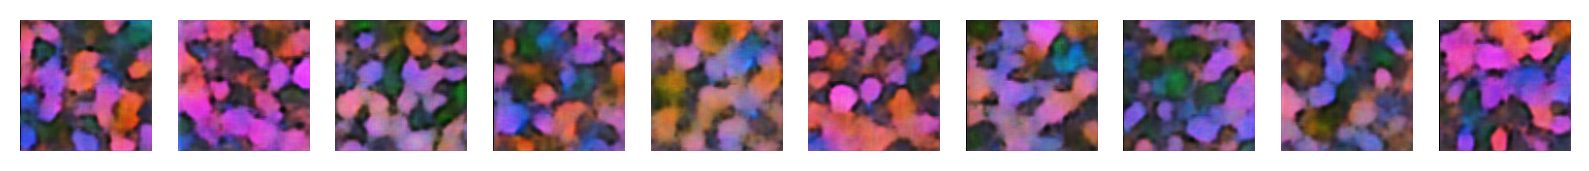

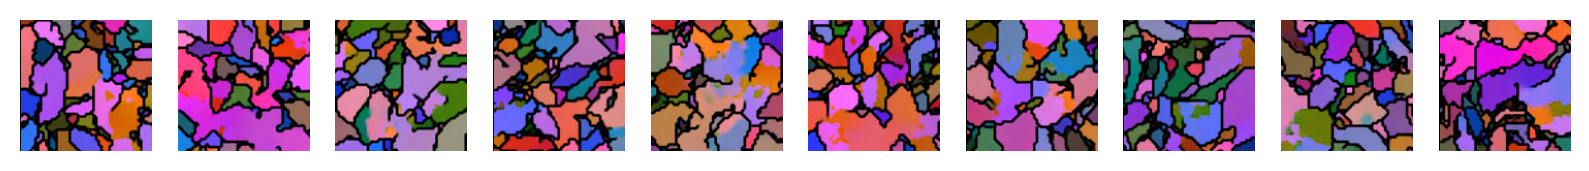

In [24]:
with torch.no_grad():
    vae.to(device)
    vae.eval()
    
    diffusion.to(device)
    diffusion.eval()
    images_vae = vae.sample(10).to(device)
    
    _, images_pre = generate(10, device, images_vae)
    
    show(images_vae)
    show(images_pre)

### Latent feature representation

/Users/liaoweijie/anaconda3/envs/pt2x/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/liaoweijie/anaconda3/envs/pt2x/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/var/folders/q2/h1c52k4s1nvdpy_d__fjypnh0000gn/T/ipykernel_20208/3846359884.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


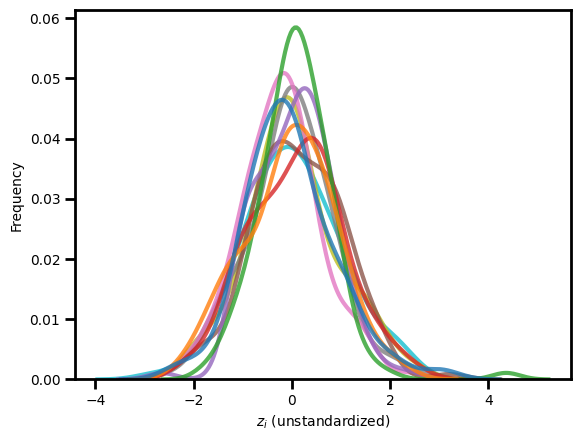

In [33]:
import seaborn as sns
with torch.no_grad():
    vae.to(device)
    for i in range(5):
        mu, logvar = vae.encode(next(iter(dataset_example)))
        z1 = vae.reparameterize(mu, logvar)
    
plt.figure()
sns.kdeplot(z1.detach().numpy().T, alpha=0.8, linewidth=3)
plt.xlabel("$z_i$ (unstandardized)")
plt.ylabel("Frequency")
plt.legend(loc='best', frameon=False)
plt.tick_params(length=7, width=2)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.show()

### Latent space exploration

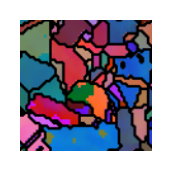

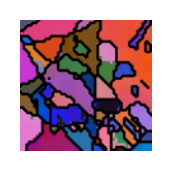

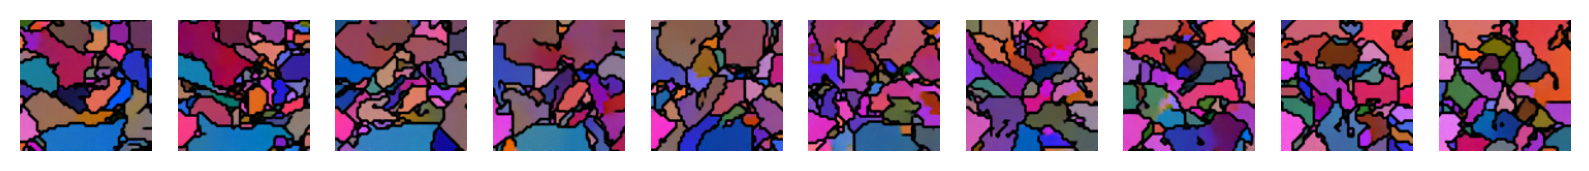

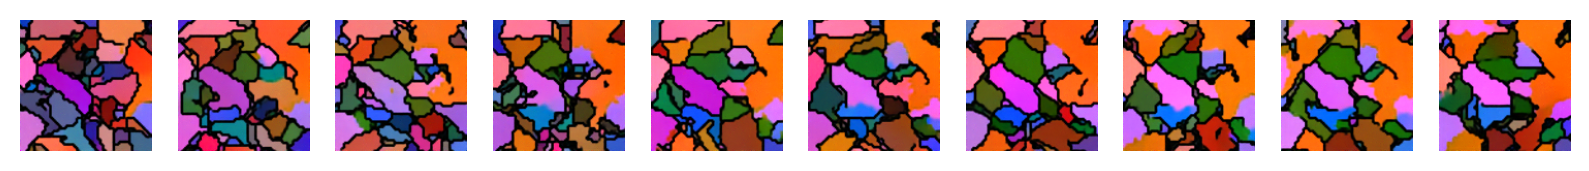

In [35]:
with torch.no_grad():
    vae.to(device)
    vae.eval()
    
    diffusion.to(device)
    diffusion.eval()
    
    m1 = next(iter(dataset_example))[0].to(device)
    m2 = next(iter(dataset_example))[1].to(device)
    
    mu1, logvar1 = vae.encode(m1[np.newaxis, :])
    z1 = vae.reparameterize(mu1, logvar1)
    mu2, logvar2 = vae.encode(m2[np.newaxis, :])
    z2 = vae.reparameterize(mu2, logvar1)
    
    interpolated_list = []
    for i in range(1, 11, 1):
        alpha = i / 10
        interpolated_sample = z1 * (1 - alpha) + z2 * alpha
        interpolated_list.append(interpolated_sample.view(128))
    inter_images_vae = vae.decode(torch.stack(interpolated_list))
    _, interpolated_image = generate(10, device, inter_images_vae)

    
    exterpolated_list = []
    for i in range(11, 21, 1):
        alpha = i / 10
        exterpolated_sample = z1 * (1 - alpha) + z2 * alpha
        exterpolated_list.append(exterpolated_sample.view(128))
    exter_images_vae = vae.decode(torch.stack(exterpolated_list))
    _, exterpolated_images = generate(10, device, exter_images_vae)

show(m1[np.newaxis, :])
show(m2[np.newaxis, :])
show(interpolated_image)
show(exterpolated_images)